In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 73.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMaximize

# Load the data
file_path = '/content/cleaned_players.csv'  # Adjust this to your file path
data = pd.read_csv(file_path)

# Add a cost column (convert to millions)
data['cost'] = data['now_cost'] / 10

In [5]:
# Initialize the optimization problem
prob = LpProblem("FPL_Team_Selection", LpMaximize)

# Create decision variables for each player (0 = not selected, 1 = selected)
variables = [LpVariable(f"player_{i}", 0, 1, cat="Integer") for i in range(len(data))]

# Objective: Maximize total points
prob += lpSum([data.loc[i, 'total_points'] * variables[i] for i in range(len(data))])

# Constraints
# 1. Budget Constraint
prob += lpSum([data.loc[i, 'cost'] * variables[i] for i in range(len(data))]) <= 100

# 2. Squad Size Constraint
prob += lpSum(variables) == 15

# 3. Position Constraints
prob += lpSum([variables[i] for i in range(len(data)) if data.loc[i, 'element_type'] == 'GK']) == 2  # Goalkeepers
prob += lpSum([variables[i] for i in range(len(data)) if data.loc[i, 'element_type'] == 'DEF']) == 5  # Defenders
prob += lpSum([variables[i] for i in range(len(data)) if data.loc[i, 'element_type'] == 'MID']) == 5  # Midfielders
prob += lpSum([variables[i] for i in range(len(data)) if data.loc[i, 'element_type'] == 'FWD']) == 3  # Forwards


In [6]:
# Solve the optimization problem
prob.solve()

# Extract the selected players
selected_indices = [i for i in range(len(data)) if variables[i].value() == 1]
recommended_team = data.loc[selected_indices]

In [8]:
!pip install ace-tools

In [11]:
# Show the recommended team
print(recommended_team)

recommended_team.to_csv('recommended_team.csv', index=False)
print("Recommended team saved to 'recommended_team.csv'.")

from google.colab import files
files.download('recommended_team.csv')


    first_name                second_name  goals_scored  assists  \
83       Milos                     Kerkez             1        3   
123      Bryan                     Mbeumo            13        3   
134      Yoane                      Wissa            10        3   
223       Cole                     Palmer            14        7   
288     Jordan                   Pickford             0        0   
312       Alex                      Iwobi             7        3   
419    Mohamed                      Salah            18       13   
469       Amad                     Diallo             6        7   
511      Lewis                       Hall             0        4   
537        Ola                       Aina             2        0   
551    Murillo  Santiago Costa dos Santos             1        0   
558       Matz                       Sels             0        1   
561      Chris                       Wood            13        1   
565     Nikola                 Milenković       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

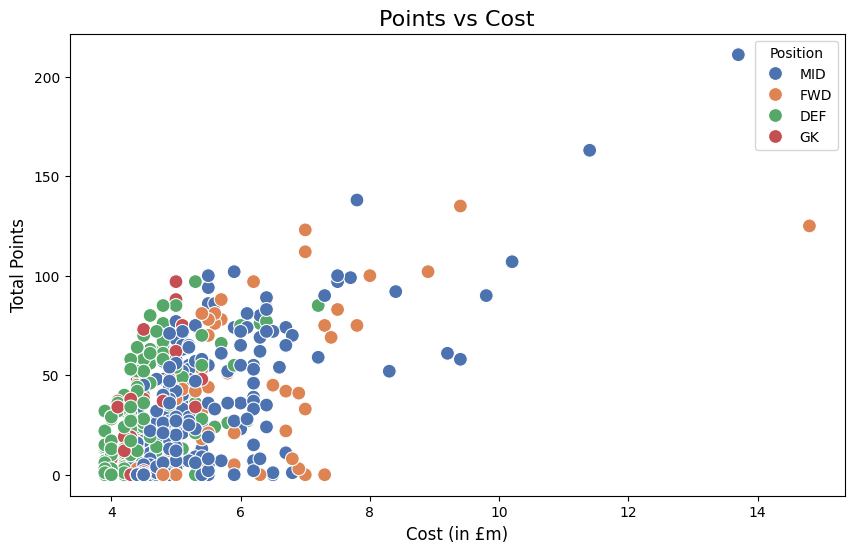

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of cost vs total points
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['cost'],
    y=data['total_points'],
    hue=data['element_type'],  # Color points by position (GK, DEF, MID, FWD)
    palette="deep",
    s=100
)
plt.title("Points vs Cost", fontsize=16)
plt.xlabel("Cost (in £m)", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.legend(title="Position")
plt.show()

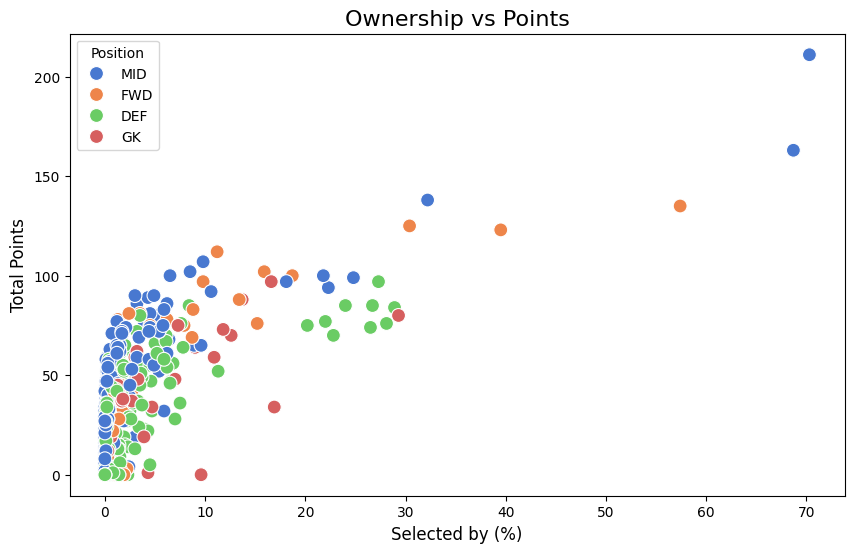

In [22]:
# Scatter plot of ownership vs total points
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['selected_by_percent'],
    y=data['total_points'],
    hue=data['element_type'],  # Color by position
    palette="muted",
    s=100
)
plt.title("Ownership vs Points", fontsize=16)
plt.xlabel("Selected by (%)", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.legend(title="Position")
plt.show()

<ipython-input-23-704d7bf450a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['element_type'], y=data['total_points'], palette="viridis")


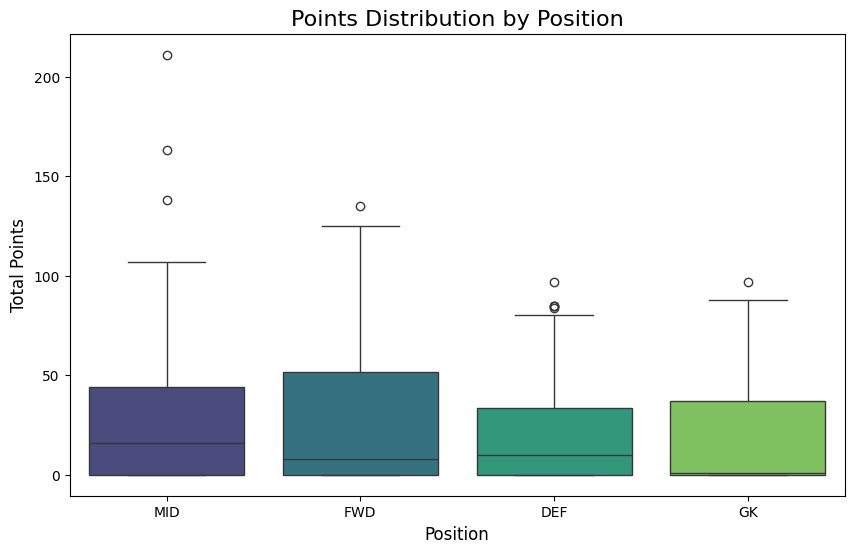

In [23]:
# Boxplot of points distribution by position
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['element_type'], y=data['total_points'], palette="viridis")
plt.title("Points Distribution by Position", fontsize=16)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.show()

In [12]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.5 MB/s eta 0:00:00


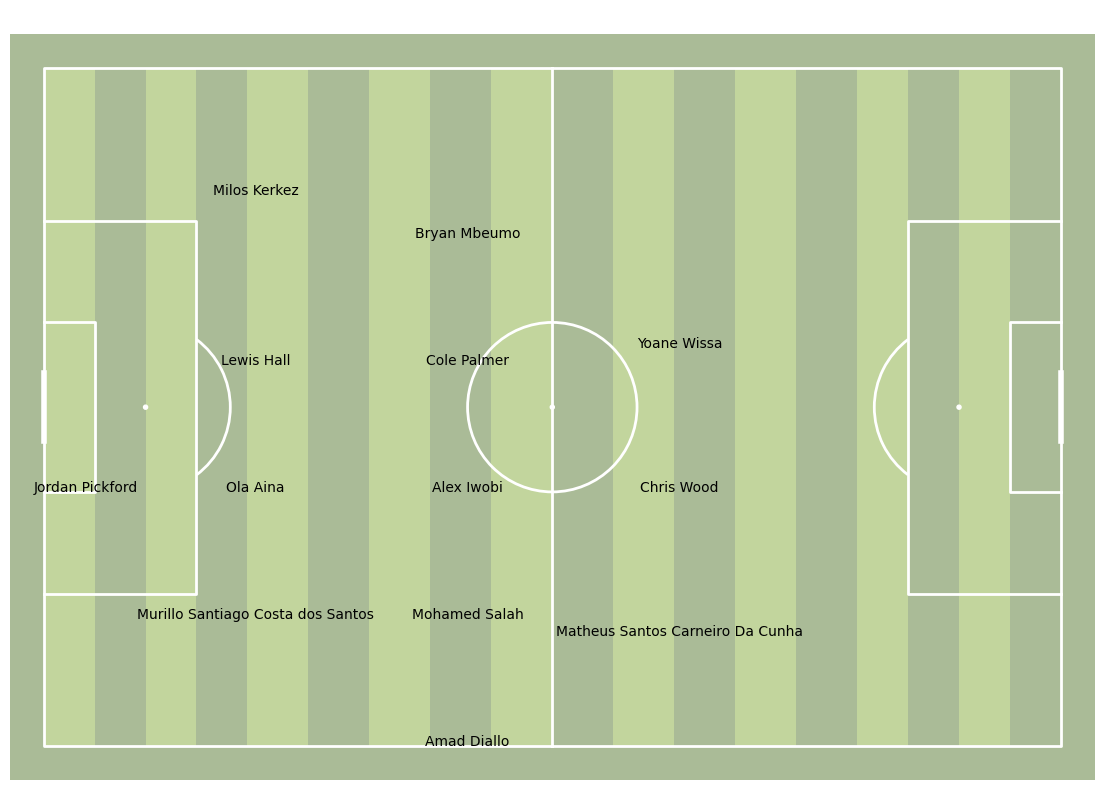

In [13]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Define positions for each player role on the pitch
def assign_positions():
    return {
        'GK': [(5, 50)],  # Goalkeeper
        'DEF': [(25, 15), (25, 35), (25, 50), (25, 65), (25, 85)],  # Defenders
        'MID': [(50, 20), (50, 35), (50, 50), (50, 65), (50, 80)],  # Midfielders
        'FWD': [(75, 33), (75, 50), (75, 67)],  # Forwards
    }

# Assign players to positions
def get_player_positions(team, positions):
    pitch_positions = []
    for role, coords in positions.items():
        players = team[team['element_type'] == role]
        for i, (_, player) in enumerate(players.iterrows()):
            if i < len(coords):  # Ensure positions are available
                pitch_positions.append((*coords[i], f"{player['first_name']} {player['second_name']}"))
    return pitch_positions

# Plot the team on a pitch
def plot_team(team):
    # Initialize the pitch
    pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Get positions and plot players
    positions = assign_positions()
    player_positions = get_player_positions(team, positions)

    for x, y, name in player_positions:
        pitch.annotate(name, (x, y), fontsize=10, ha='center', color='black', ax=ax)

    plt.title("Recommended FPL Team on a Football Pitch", fontsize=16, color='white')
    plt.show()

# Plot the recommended team
plot_team(recommended_team)


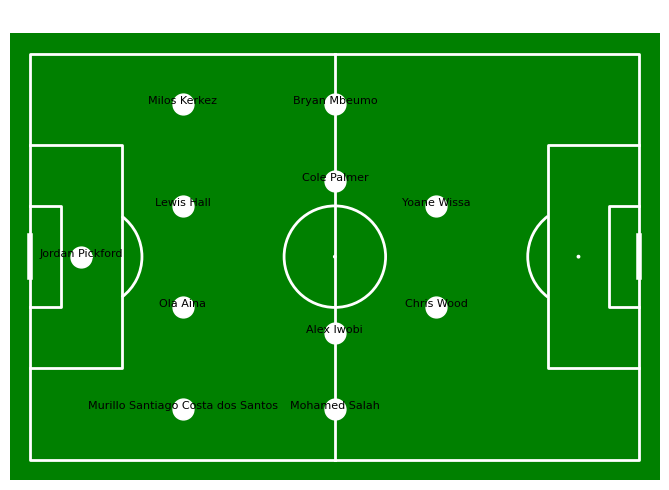

In [20]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Adjusted positions for a 4-4-2 formation
def assign_positions():
    return {
        'GK': [(10, 40)],  # Goalkeeper
        'DEF': [(30, 10), (30, 30), (30, 50), (30, 70)],  # Defenders
        'MID': [(60, 10), (60, 25), (60, 55), (60, 70)],  # Midfielders
        'FWD': [(80, 30), (80, 50)],  # Forwards
    }

# Match players to positions
def get_player_positions(team, positions):
    pitch_positions = []
    for role, coords in positions.items():
        players = team[team['element_type'] == role]
        for i, (_, player) in enumerate(players.iterrows()):
            if i < len(coords):  # Ensure enough positions
                pitch_positions.append((*coords[i], f"{player['first_name']} {player['second_name']}"))
    return pitch_positions

# Plot the team on a smaller pitch
def plot_team_with_icons_small(team, formation='4-4-2'):
    # Initialize the pitch
    pitch = Pitch(pitch_color='green', line_color='white')
    fig, ax = pitch.draw(figsize=(8, 5))  # Smaller pitch size

    # Get positions and players
    positions = assign_positions()  # Adjust for the desired formation
    player_positions = get_player_positions(team, positions)

    # Plot player names with jerseys
    for x, y, name in player_positions:
        # Add a circle or icon for the jersey
        ax.plot(x, y, 'o', color='white', markersize=15)  # Smaller jersey icon
        # Add player name
        pitch.annotate(name, (x, y), fontsize=8, ha='center', color='black', ax=ax)

    plt.title("Recommended FPL Team", fontsize=14, color='white')
    plt.show()

# Run the visualization with the recommended team
plot_team_with_icons_small(recommended_team)
